# **Development of a 3D + t segmentation tool of the aorta in 4D Flow MRI**

**Context**: Cardiovascular diseases are responsible for half of deaths in France with an estimated cost of 200 billion / year. The aorta, the largest artery in the human body, provides blood supply to the body and maintains continuous blood flow despite the pulsating function of the heart. However, various impairments will cause a modification of the geometric and mechanical properties of the aortic wall and consequently a reduction in the performance of the central circulatory system.
---

**Objective**: In order to automatically locate the ascending and descending aorta, I propose a Machine Learning technique, more precisely, Deep Learning. For this, we must first master our database which includes 9,944 aortic images accompanied with the corresponding masks extracted from the 150 4D Flow MRI sequences.

The data can be found in the following link: https://filesender.renater.fr/?s=download&token=312b0573-54a2-4417-b3cb-60eb8e4e5389
To facilitate its import from any computer, I created in my Github a directory called Aorta: https://github.com/anhqttruong/Aorta.git and reproduce it here via the Clone command.

# **Preparing the environment**

> We import the necessary libraries as well as the gits which allow to reproduce specific functionalities not available in the form of common commands for the future.

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q git+https://github.com/tensorlayer/tensorlayer.git
!pip install -q --no-deps tensorflow-addons~=0.7
import tensorflow_addons as tfa
import glob
from google.colab import files
import numpy as np
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as image
import keras
import matplotlib
import tensorflow as tf
import matplotlib.pylab as plt
from tensorflow import keras
import os
from PIL import Image
import numpy as np
from os import listdir
from tensorflow_examples.models.pix2pix import pix2pix
import tensorlayer as tl
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
#Créer un fichier dans ce Colab pour stocker les images téléchargées 
training_dir='/content/Aorta'
# Télécharger les images et masques de l'aorte si cela n'est pas encore fait.
if not os.path.exists(training_dir):
    print('Loading data...')
    os.system('git clone https://github.com/anhqttruong/Aorta.git ./Aorta')
    print('Done!')


     |████████████████████████████████| 3.3MB 5.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


Using TensorFlow backend.


Loading data...
Done!


Comme les images sont enregistrées à partir des séquences IRM différentes dans de différents endroits,ainisi, ne sont pas compatibles avec les pré-requis pour l'entraînement du réseau de neurones au niveau d'ordre des images, on va, par conséquence, créer des listes qui peuvent nous aider à les concaténer dans l'ordre au fur et à mesure de la lecture des séquences.

In [ ]:
import cv2

train_im=[]
train_ma=[]
validation_im=[]
validation_ma=[]

for f in os.listdir('/content/Aorta/train_data') : #pour chaque répertoire EA & EB
  for k in range(1,999): #pour chaque image numérotée dans l'ordre croissante
    i=str(0)+str(k)+'.png' #suffixe 01.png, 02.png, ...
    for filename in glob.glob('/content/Aorta/train_data/'+f+'/Modules/*'): #pour chaque module du répertoire EA/EB actuel
      if filename.endswith(i): #si le suffixe d'une image est i
        train_im.append(filename)
    for filename2 in glob.glob('/content/Aorta/train_data/'+f+'/Masks/*'): #pour chaque masks du répertoire EA/EB actuel
      if filename2.endswith(i): #si le suffixe de l'image est i
        train_ma.append(filename2)

# 0-Padding les images pour les convertir en une même dimension sans avoir à utiliser resize()
for f in os.listdir('/content/Aorta/validation_data') : #pour chaque répertoire EA & EB
  for k in range(1,999): #pour chaque image numérotée dans l'ordre croissante
    i=str(0)+str(k)+'.png' #suffixe 01.png, 02.png, ...
    for filename in glob.glob('/content/Aorta/validation_data/'+f+'/Modules/*'): #pour chaque module du répertoire EA/EB actuel
      if filename.endswith(i): #si le suffixe d'une image est i
        validation_im.append(filename)
    for filename2 in glob.glob('/content/Aorta/validation_data/'+f+'/Masks/*'): #pour chaque masks du répertoire EA/EB actuel
      if filename2.endswith(i): #si le suffixe de l'image est i
        validation_ma.append(filename2)


## **Traitement des images**


> Grâce aux dispositif tf.data de tensorflow, nous allons, dans cette partie, mettre en place les bases de données compatibles avec l'entraînement du réseau.



In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_WIDTH=224
IMG_HEIGHT=224

#Convertir les listes des chemins dans la partie d'avant en tf.data.Dataset puis compresser les couples d'image/mask.
train_im = tf.data.Dataset.list_files(train_im,shuffle=False)
train_ma=tf.data.Dataset.list_files(train_ma,shuffle=False)
train_dataset= tf.data.Dataset.zip((train_im, train_ma))

validation_im = tf.data.Dataset.list_files(validation_im,shuffle=False)
validation_ma=tf.data.Dataset.list_files(validation_ma,shuffle=False)
validation_dataset= tf.data.Dataset.zip((validation_im, validation_ma))

#train_dataset = train_dataset.concatenate(validation_dataset)


In [ ]:
#Preprocess the image / mask paths then send a dictionary for training in the next part.
def process_path(file_path,file_path2):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_png(img, channels=3)

  mask = tf.io.read_file(file_path2)
  mask=tf.image.decode_png(mask, channels=1)

  return {'image': img, 'segmentation_mask': mask}

#Apply transformations to our datasets
train = train_dataset.map(process_path)
validation=validation_dataset.map(process_path)


In [ ]:
#Define more transformations: normalize, resize with crop or 0 padding
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor):
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

def load_image_train(datapoint: dict):
    
    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], IMG_WIDTH, IMG_HEIGHT)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], IMG_WIDTH, IMG_HEIGHT)

    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint: dict):

    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], IMG_WIDTH, IMG_HEIGHT)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], IMG_WIDTH, IMG_HEIGHT)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def orginal_image_shape(datapoint: dict):
  IMG_WIDTH = datapoint['image'].shape[0]
  IMG_HEIGHT = tf.image.decode_image(datapoint['segmentation_mask'], channels=3).shape[1]
  return IMG_WIDTH,IMG_HEIGHT


In [ ]:
BATCH_SIZE = 1

BUFFER_SIZE = 1000

dataset = {"train": train, "val": validation}

dataset['train'] = train.map(load_image_train)

dataset['val'] = validation.map(load_image_test)
dataset['val'] = dataset['val'].batch(BATCH_SIZE)

print(dataset['train'])
print(dataset['val'])


<MapDataset shapes: ((224, 224, 3), (224, 224, 1)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>


To better visualize the effect of the increase in images via different random transformations, we will build 2 databases with and without augmentation on which our network will learn to locate the asc and desc aorta.

In [ ]:
SEED=1
delta = 0.5
lower_saturation = 0.1
upper_saturation = 0.9
lower_value = 0.2
upper_value = 0.8

def augment(image,mask):
  image2=image
  mask2=mask
  
  #if tf.random.uniform((),0,1) > 0.5:
  #Mean filter pour supprimer les 'bruits' en parcourant pixel par pixel de l'image puis remplace chaque pixel par la moyenne de son entourage.
  # image2 = tfa.image.mean_filter2d(image2, filter_shape=11)
  image2= tf.image.adjust_brightness(image2, tf.random.uniform((),0,1))
  
  return image2,mask2


In [ ]:
BATCH_SIZE = 32
TRAIN_LENGTH = 9644
BUFFER_SIZE = TRAIN_LENGTH
STEPS_PER_EPOCH = TRAIN_LENGTH // (BATCH_SIZE)
VALIDATION_STEPS = 300 // BATCH_SIZE
SEED=1

#Dupliquer the original dataset
augmented_train_dataset=dataset['train']
non_augmented_train_dataset=dataset['train']

#Dataset with augmented images
augmented_train_batches = (
    augmented_train_dataset
    .shuffle(BUFFER_SIZE)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE,drop_remainder=False)
    .prefetch(AUTOTUNE)
    .repeat()
    )

#Dataset without increasing images
non_augmented_train_batches = (
    non_augmented_train_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE,drop_remainder=False)
    .prefetch(AUTOTUNE)
    .repeat()
    )


## **Construction of the neural network**

> In this part, we will define the architecture of the U-net neural network which will help us to segment the aorta automatically. In order to learn robust features while reducing the number of trainable features (to learn), we will recover a pre-trained model which will be used to extract important features from an image (encode) such as the context, the aorta ascending and descending.

In [ ]:
#The encoder part of the MobileNetV2 network will be used for our analysis as a context and object extractor, i.e. Encoder
OUTPUT_CHANNELS = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(448, 3),  # 4x4 -> 8x8
    pix2pix.upsample(224, 3),  # 8x8 -> 16x16
    pix2pix.upsample(112, 3),  # 16x16 -> 32x32
    pix2pix.upsample(56, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)


## **Network drive**

Before training the network, we will define the metrics to evaluate the performance of our model:
 
1. Loss function: we are going to use SparseCategoricalCrossentropy because the classes {0,1,2} provided are of integer type and not one-hot-encoding in which case we must call on CategoricalCrossentropy.

2. Metric: Accuracy gives us the frequency of correct predictions.

The Dice loss and iou score will be used at the end and not during the training because they give results of type float and not 0,1,2 according to my observation.

In [ ]:
#After having tested 40 iterations (epochs), 20 epochs are enough to make the result of the model converge
EPOCHS = 40


### **Training with increased frames**

By taking again the base of the images with the increase thanks to the various operations of random modification of the level of luminosity, filtering the 'noises', flip right / left, we will train our network defined above.

In [ ]:
model_aug = unet_model(OUTPUT_CHANNELS)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=2, min_lr=0)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

model_aug.compile(optimizer=optimizer,
              #loss=dice_loss,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

aug_history=model_aug.fit(augmented_train_batches, 
          epochs=EPOCHS,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          validation_data=dataset['val'],
          )


In [ ]:
model_aug.save('Model_with_augmentation.h5')


**Observation:** Après 20 itérations, on voit bien que la perte sur les images de validation tournent autour de 0.0020 comparée avec celle de l'entraînement 0.0018. Ceci nous indique qu'il n'y a pas beaucoup de overfitting jusque là.

### **Entraînement sans augmentation d'images**

Cette fois ci, faisons la même chose mais seulement avec des images originales.

In [ ]:
model_no_aug = unet_model(OUTPUT_CHANNELS)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=2, min_lr=0)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
model_no_aug.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

no_aug_history=model_no_aug.fit(non_augmented_train_batches,
          epochs=EPOCHS,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          validation_data=dataset['val'],
          callbacks=[callback,reduce_lr]
          )


Epoch 1/40
301/301 [==============================] - 27s 90ms/step - loss: 0.0406 - accuracy: 0.9895 - val_loss: 0.0138 - val_accuracy: 0.9949 - lr: 0.0010
Epoch 2/40
301/301 [==============================] - 49s 162ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0039 - val_accuracy: 0.9986 - lr: 0.0010
Epoch 3/40
301/301 [==============================] - 49s 162ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0033 - val_accuracy: 0.9988 - lr: 0.0010
Epoch 4/40
301/301 [==============================] - 49s 161ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0035 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 5/40
301/301 [==============================] - 49s 163ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0027 - val_accuracy: 0.9989 - lr: 0.0010
Epoch 6/40
301/301 [==============================] - 49s 163ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0028 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 7/40
301/301 [==============================] -

In [ ]:
model_no_aug.save('Model_without_augmentation.h5')


**Observation:** The loss on the images for validation is around 0.0020 and 0.00046 for training. Such a difference means a slight phenomenon of overfitting.

## **View the results**

To see the performance of our trained model, we will take 10 images taken at random from the validation corpus (300 images = 4 MRI sequences) then do the automatic segmentation and visualize the result on site.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask','Overlap']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.subplot(1, len(display_list), i+1)
  plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[2]),alpha=0.3)
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

def show_predictions(dataset=None, num=1,model=None):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)[0],image[0]])


**Avec augmentation des images, nous obtenons le résultat suivant**

In [ ]:
show_predictions(dataset['val'],10,model=model_aug)


We see that there is a small part that was poorly predicted for some images.

**Without increasing the images we get the following result**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


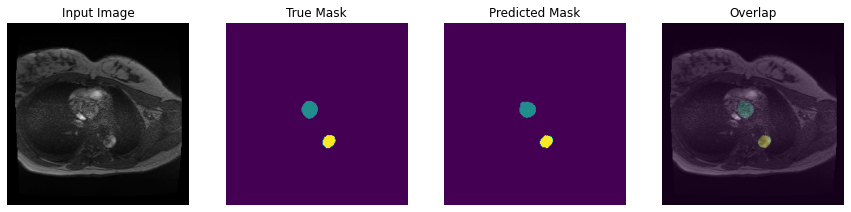

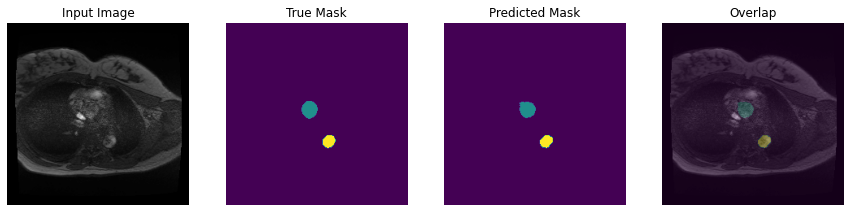

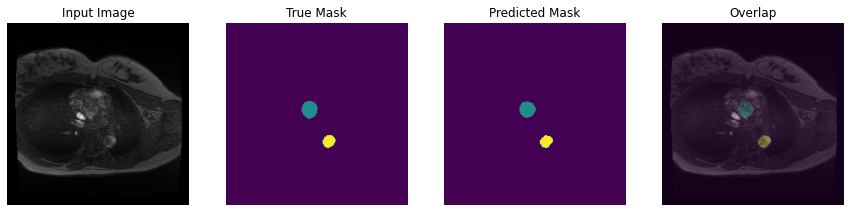

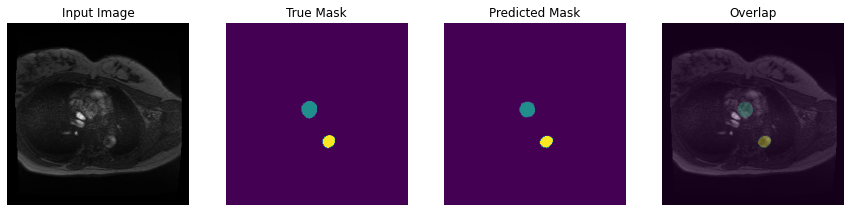

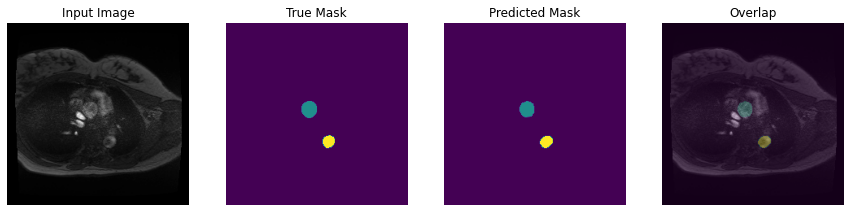

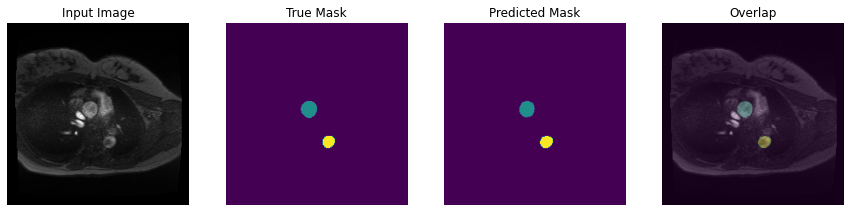

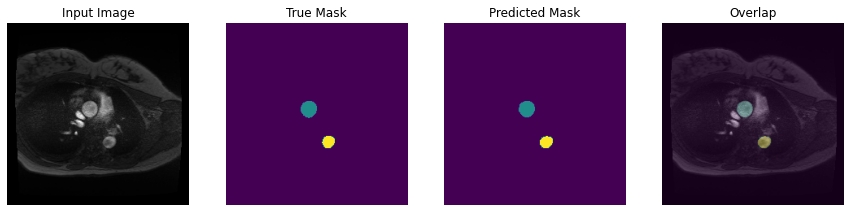

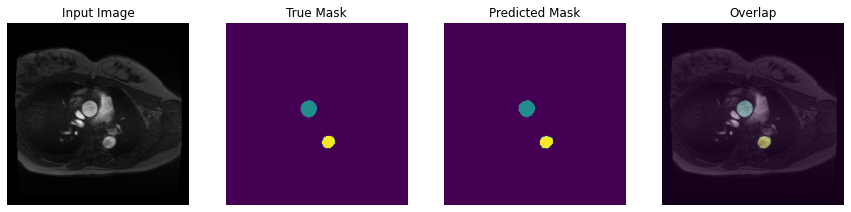

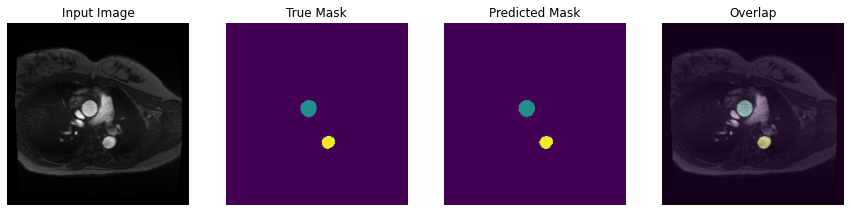

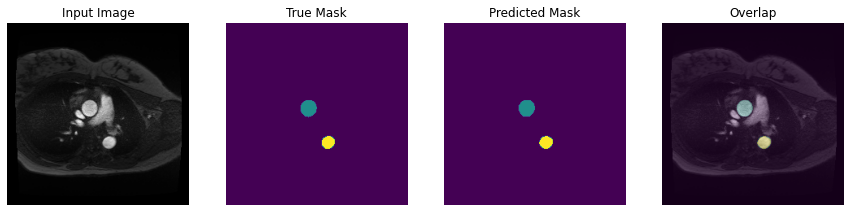

In [ ]:
show_predictions(dataset['val'],10,model=model_no_aug)


With only 9644 original images, our model seems to give us very satisfactory results. Now let's move on to quantitative analysis using the training history and the IoU and Dice loss metrics.

## **Comparison of results**

The graph that illustrates the evolution of accuracy during training tells us that after about 10 iterations, the performance of our model converges.

(0.0, 40.0)

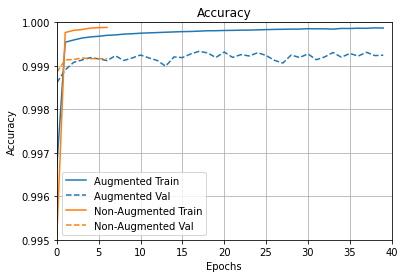

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = 'accuracy')
plt.title("Accuracy")
plt.ylim([0.995,1])
plt.xlim([0,40])


(0.0, 40.0)

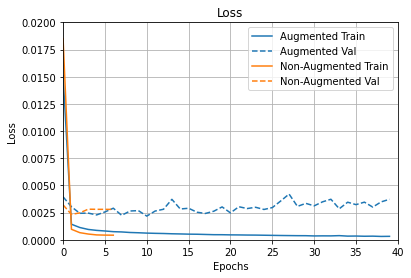

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = 'loss')
plt.title("Loss")
plt.ylim([0,0.02])
plt.xlim([0,40])


> From the 2 graphs, we see that the model gives better results from 4 iterations. Now, let's see what our model's IoU score is on 300 validation images and 9644 training images.


In [ ]:
NUM_VALIDATION_IMAGES=300
comptage=1
val_iou_no_aug = tf.keras.metrics.MeanIoU(num_classes=3)
val_iou_aug = tf.keras.metrics.MeanIoU(num_classes=3)

IMG_WIDTH,IMG_HEIGHT=orginal_image_shape(dataset['val'])

dataset['val'] = validation.map(load_image_test)
dataset['val'] = dataset['val'].batch(BATCH_SIZE)

for image, mask in dataset['val'].take(NUM_VALIDATION_IMAGES):
  val_pred_mask_no_aug = model_no_aug.predict(image)
  val_pred_mask_aug = model_aug.predict(image)
  val_pred_mask_no_aug=tf.image.resize_with_crop_or_pad(val_pred_mask_no_aug,IMG_WIDTH,IMG_HEIGHT)
  tf.keras.preprocessing.image.save_img('/content/Predicted_Mask_'+str(comptage)+'.png',create_mask(val_pred_mask_no_aug[0]))
  #Calcul de la moyenne des scores IoU
  _ = val_iou_no_aug.update_state(mask, create_mask(val_pred_mask_no_aug))
  _ = val_iou_aug.update_state(mask, create_mask(val_pred_mask_aug))
  comptage=comptage+1


In [ ]:
NUM_TRAINING_IMAGES=150
train_iou_no_aug = tf.keras.metrics.MeanIoU(num_classes=3)
train_iou_aug = tf.keras.metrics.MeanIoU(num_classes=3)

for image, mask in augmented_train_batches.take(NUM_TRAINING_IMAGES):
  train_pred_mask_no_aug = model_no_aug.predict(image)
  train_pred_mask_aug = model_aug.predict(image)
  _ = train_iou_no_aug.update_state(mask, create_mask(train_pred_mask_no_aug))
  _ = train_iou_aug.update_state(mask, create_mask(train_pred_mask_aug))


In [ ]:
print(f"Sans augmentation des images, la moyenne IoU pour les {NUM_TRAINING_IMAGES*64:d} images de l'entraînement, donc 4 séquences IRM, est {train_iou_no_aug.result().numpy():.2f} et {val_iou_no_aug.result().numpy():.2f} pour {NUM_VALIDATION_IMAGES:d} images de validation")

print(f"Avec l'augmentation des images, la moyenne IoU pour les {NUM_TRAINING_IMAGES*64:d} images de l'entraînement, donc 4 séquences IRM, est {train_iou_aug.result().numpy():.2f} et {val_iou_aug.result().numpy():.2f} pour {NUM_VALIDATION_IMAGES:d} images de validation")


##**Conclusion**
From the results obtained, we will retain the model trained purely with the original images.